In [322]:
# %tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
from time import time
import tensorflow as tf
# need tensorflow 1.x version
# use tensorflow module to improve matrix caclulation speed
print(tf.__version__)

1.15.2


In [118]:
plt.rcParams['font.family'] = 'Serif'

In [406]:
class KuramotoOsc_tf:
    def __init__(self, k, num_osc, t_max, w0=None, theta=None, ext_A1=0, ext_w1=0, ext_A2=0, ext_w2=0, w_r=0, tau_ext=0, tau_lag=0, noise_std=0, dt=0.001):
        if w0 is None:
            w0 = abs(np.random.normal(loc=1, scale=0, size=[1, num_osc]))
        if theta is None:
            theta = np.random.normal(loc=0, scale=5, size=[1, num_osc])
        self.N = num_osc
        self.k = k
        self.ext_amp1, self.ext_w1 = ext_A1, ext_w1
        self.ext_amp2, self.ext_w2 = ext_A2, ext_w2
        self.tau_ext, self.tau_lag = tau_ext, tau_lag
        self.w_r = w_r
        self.noise_std = noise_std
        self.t_max, self.dt = t_max, dt
        self.itr_all = int(t_max/dt)
        self.w0 = np.array(w0)
        self._init_arrays()
        self.theta_list[0, :] = theta
        self.r_coh[0], self.psi_coh[0] = self.get_coh(0)
        
    def run_model(self):
        # create tensorflow model
        theta_tf = tf.placeholder(tf.float32, shape=(1, self.N))
        F = tf.placeholder(tf.float32, shape=(1, self.N))
        K = tf.placeholder(tf.float32, shape=(1, self.N))
        w0_tf = tf.constant(self.w0, dtype=tf.float32)
        ## use midpoint method to solve ODE
        # Euler 1st
        dsin1 = tf.math.sin(tf.subtract(tf.transpose(theta_tf), theta_tf))
        df1 = tf.add(tf.add(tf.matmul(K, dsin1), w0_tf), F)
        temp_theta = tf.add(theta_tf, tf.multiply(df1, self.dt))
        # Euler 2nd
        dsin2 = tf.math.sin(tf.subtract(tf.transpose(temp_theta), temp_theta))
        df2 = tf.add(tf.add(tf.matmul(K, dsin2), w0_tf), F)
        # update theta
        theta_next = tf.add(theta_tf, tf.multiply(tf.add(df1, df2), self.dt/2))
        
        with tf.Session() as sess:
            for i in range(self.itr_all):
                self.theta_list[i+1, np.newaxis, :] = sess.run(theta_next, feed_dict={theta_tf: self.theta_list[i, np.newaxis, :],
                                                                                           K: self.get_k(i),
                                                                                           F: self.external_drive(i)})
                self.theta_list[i+1, :] = np.round(self.theta_list[i+1, :], 10)
                self.r_coh[i+1], self.psi_coh[i+1] = self.get_coh(i+1)
    
    def get_k(self, i):
        # calculate K
        return self.k /(((self.get_freq(i))**2-self.w_r**2)**2+1) / self.N
    
    def external_drive(self, i):
        # AS and OS
        self.phs_as[i, :] = self.ext_w1*self.t[i] + np.random.normal(loc=0, scale=self.noise_std, size=(1, self.N))
        self.phs_os[i] = self.ext_w2*(self.t[i] + self.tau_lag + self.tau_ext)
        return (self.ext_amp1 * np.sin(self.phs_as[i, np.newaxis, :] - self.theta_list[i, np.newaxis, :])
                + self.ext_amp2 * np.sin(self.phs_os[i] - self.theta_list[i, np.newaxis, :]))
    
    def get_freq(self, i):
        return (self.theta_list[i, np.newaxis, :]-self.theta_list[i-1, np.newaxis, :])/self.dt
    
    def get_coh(self, i):
        # calculate r and \psi
        temp = np.average(np.exp(1j * self.theta_list[i, :]))
        r = abs(temp)
        psi = np.log(temp / r)
        return r, psi.imag
    
    def _init_arrays(self):
        self.t = np.arange(0, self.t_max+self.dt/10, self.dt) # t = [0, self.dt]
        self.theta_list = np.zeros([self.itr_all+1, self.N]) # save theta
        self.phs_as = np.zeros([self.itr_all, self.N])
        self.phs_os = np.zeros(self.itr_all)
        self.r_coh = np.zeros(self.itr_all+1)
        self.psi_coh = np.zeros(self.itr_all+1)
        
def show_result(model, title, ymax=1):
    # plot result
    plt.figure(dpi=150, figsize=(6, 3))
    # subplot 211
    plt.subplot(211)
    plt.plot(model.t, model.r_coh, 'k', lw=0.8)
    plt.ylabel('r', fontsize=14)
    plt.title(title)
    plt.xlim([0, model.t_max])
    plt.ylim([0, ymax])
    plt.yticks([0, ymax/2, ymax])
    # subplot 212
    plt.subplot(212)
    plt.plot(model.t, model.r_coh * np.sin(model.psi_coh), 'k', lw=0.8)
    plt.xlim([0, model.t_max])
    plt.ylim([-ymax, ymax])
    plt.yticks([-ymax, -ymax/2, 0, ymax/2, ymax])
    plt.xlabel('time t', fontsize=14)
    plt.ylabel(r'r * sin($\phi$)', fontsize=14)
    # show figure
    plt.tight_layout()
    plt.show()

# See results of assr, out of phase and advanced condition

## Cortical response

In [396]:
# condition
kmax = 0.8
tmax, dt = 100, 0.01
w_r = 2*np.pi/5
num_osc = 1000
# initial value
w0 = abs(np.random.normal(loc=w_r, scale=0.5, size=[1, num_osc]))
theta0 = abs(np.random.normal(loc=0, scale=20, size=[1, num_osc]))

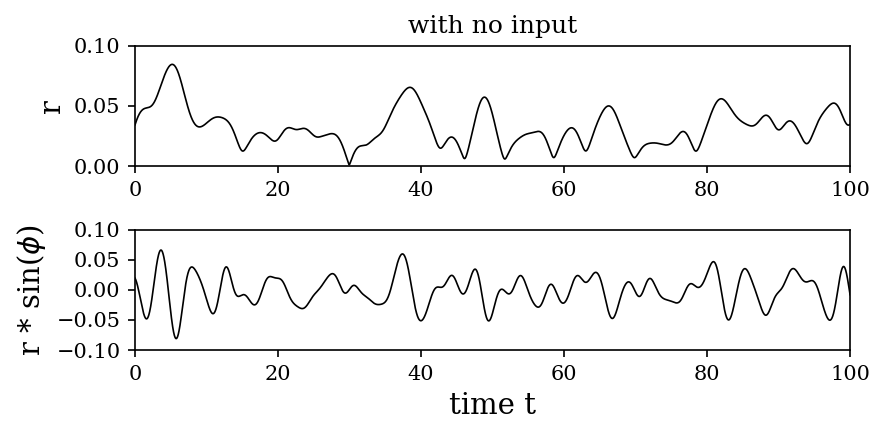

In [397]:
# with no input
model0 = KuramotoOsc_tf(kmax, num_osc, tmax, dt=dt, w0=w0, theta=theta0, ext_A1=0, ext_A2=0, noise_std=0)
model0.run_model()
show_result(model0, 'with no input', 0.1)

In [399]:
# amplitudes of AS&OS
A_as = 0.3 # amplitude of the as input
A_os = 0.09 # amplitude of the os input
tau_ext = np.array([0, -np.pi/2, np.pi]) / w_r # (in-phase, advanced, out of phase)
tau_lag = np.pi/(6*w_r) # \tau_{lag}
noise_std=1.5 # standart deviation of the Gaussian noise

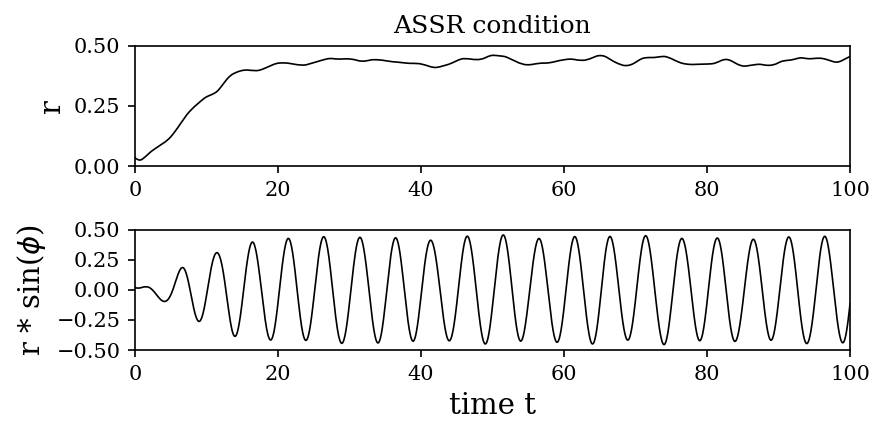

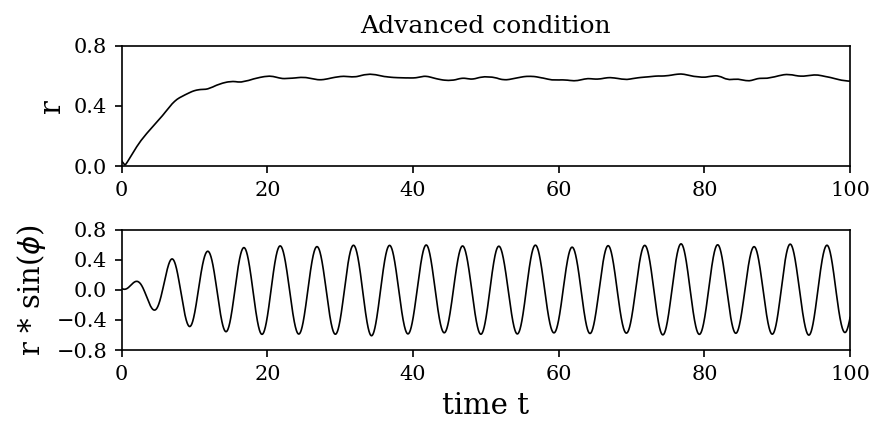

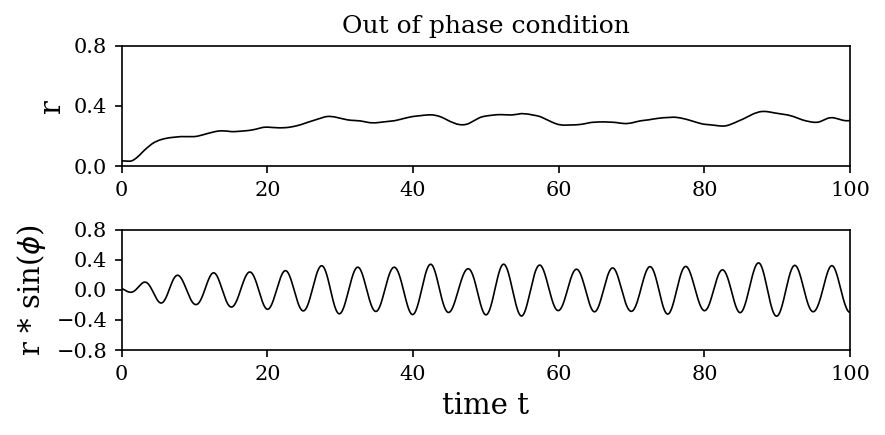

In [401]:
# ASSR(Auditory Steady State Response) condition, as
model_as = KuramotoOsc_tf(kmax, num_osc, tmax, dt=dt, w0=w0, theta=theta0, ext_A1=A_as, ext_A2=0, ext_w1=w_r, noise_std=noise_std, w_r=w_r)
model_as.run_model()
show_result(model_as, 'ASSR condition', 0.5)
# Advanced condition, adv
model_adv = KuramotoOsc_tf(kmax, num_osc, tmax, dt=dt, w0=w0, theta=theta0, ext_A1=A_as, ext_A2=A_os, ext_w1=w_r, ext_w2=w_r, noise_std=noise_std, w_r=w_r, tau_ext=tau_ext[1], tau_lag=tau_lag)
model_adv.run_model()
show_result(model_adv, 'Advanced condition', 0.8)
# Out of phase condition, out
model_out = KuramotoOsc_tf(kmax, num_osc, tmax, dt=dt, w0=w0, theta=theta0, ext_A1=A_as, ext_A2=A_os, ext_w1=w_r, ext_w2=w_r, noise_std=noise_std, w_r=w_r, tau_ext=tau_ext[2], tau_lag=tau_lag)
model_out.run_model()
show_result(model_out, 'Out of phase condition', 0.8)

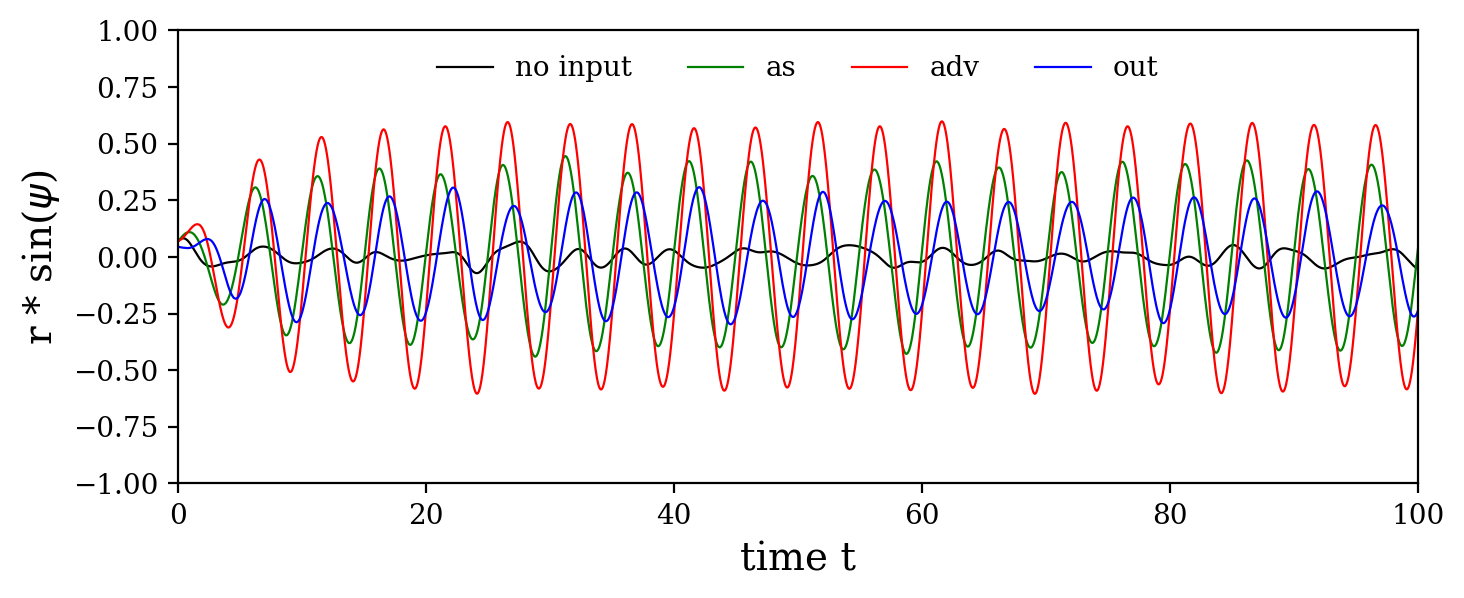

In [225]:
# show all results - no input, as, adv out
plt.figure(dpi=200, figsize=(8, 3))
# plot graphs
plt.plot(model0.t, model0.r_coh * np.sin(model0.psi_coh), 'k', lw=0.8, label='no input')
plt.plot(model_as.t, model_as.r_coh * np.sin(model_as.psi_coh), 'g', lw=0.8, label='as')
plt.plot(model_adv.t, model_adv.r_coh * np.sin(model_adv.psi_coh), 'r', lw=0.8, label='adv')
plt.plot(model_out.t, model_out.r_coh * np.sin(model_out.psi_coh), 'b', lw=0.8, label='out')
# set labels and limits
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1), edgecolor='w', ncol=4)
plt.xlim([0, tmax])
plt.ylim([-1, 1])
plt.xlabel('time t', fontsize=14)
plt.ylabel(r'r * sin($\psi$)', fontsize=14)

plt.show()

In [227]:
def add_lfp(model):
    # calculate LFP = r * sin(\psi)
    model.lfp = model.r_coh * np.sin(model.psi_coh)
add_lfp(model0)
add_lfp(model_as)
add_lfp(model_adv)
add_lfp(model_out)

## Phase diagram

In [229]:
def get_derivative(model):
    # calculate (\psi_{n+1} - \psi_{n}) / dt
    return (model.lfp[1:] - model.lfp[:-1]) / model.dt

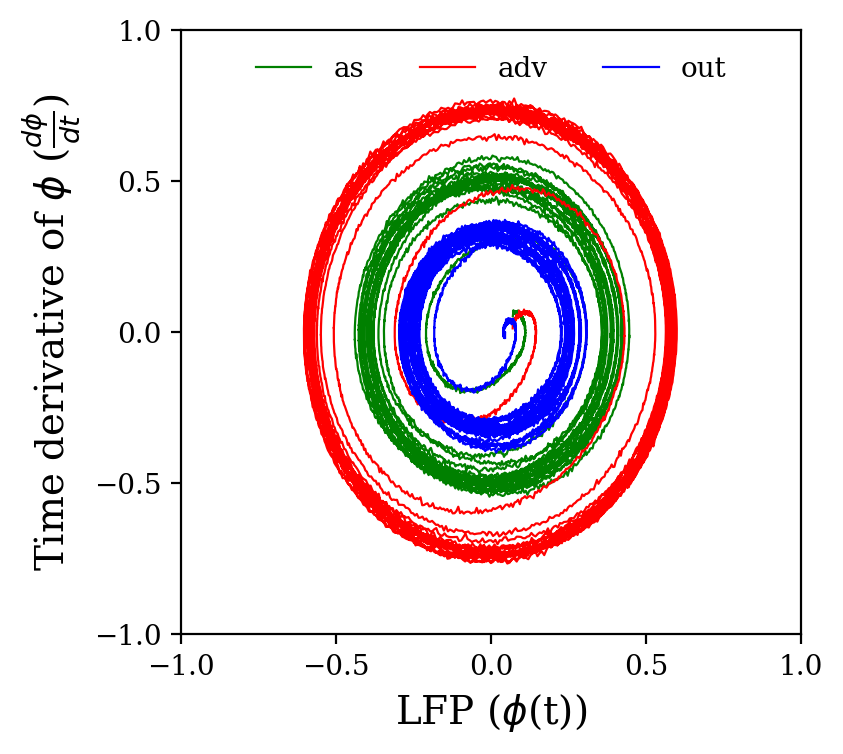

In [246]:
plt.figure(dpi=200, figsize=(4, 4))
# plot graphs
plt.plot(model_as.lfp[1:], get_derivative(model_as), 'g', lw=0.8, label='as')
plt.plot(model_adv.lfp[1:], get_derivative(model_adv), 'r', lw=0.8, label='adv')
plt.plot(model_out.lfp[1:], get_derivative(model_out), 'b', lw=0.8, label='out')
# set labels and limits
ticks = [-1 + i*0.5 for i in range(5)]
plt.xlim([-1, 1])
plt.xticks(ticks)
plt.ylim([-1, 1])
plt.yticks(ticks)
plt.xlabel(r'LFP ($\phi$(t))', fontsize=14)
plt.ylabel(r'Time derivative of $\phi$ ($\frac{d\phi}{dt}$)', fontsize=14)
plt.legend(loc='upper center', ncol=3, edgecolor='w')

plt.show()

## Power spectrum of LFP

In [270]:
from scipy.interpolate import interp1d

def get_fft(data, dt, npts=None):
    # get Fouier transform
    if npts is None:
        npts = len(data) + 1
    fft_data = np.fft.fft(data, npts)
    if npts % 2 == 0:  # even #
        ind = int(npts / 2 + 1)
        fft_data = fft_data[:ind]
        fft_data[1:-1] = 2 * fft_data[1:-1]
    else:  # odd #
        ind = int((npts + 1) / 2)
        fft_data = fft_data[:ind]
        fft_data[1:] = 2 * fft_data[1:]
    fft_data = abs(fft_data) / npts # Fourier spectrums
    freq = 1 / dt * np.arange(ind) / npts # frequencies
    return fft_data, freq

def get_ps(model):
    model.fft, model.fft_freq = get_fft(model.lfp[model.t > 80], model.dt) # steady state

def fft_interp1d(model, f_range):
    # "cubic" interpolation
    model.fft_freq1 = np.linspace(f_range[0], f_range[1], 1000)
    interp = interp1d(model.fft_freq/(w_r/(2*np.pi)), abs(model.fft), kind='cubic')
    model.fft1 = interp(model.fft_freq1)

In [271]:
f_all = np.linspace(0.01, 2*w_r, 11)
get_ps(model_as)
get_ps(model_adv)
get_ps(model_out)
# interpolate fft results
fft_interp1d(model_as, [0.8, 1.2])
fft_interp1d(model_adv, [0.8, 1.2])
fft_interp1d(model_out, [0.8, 1.2])

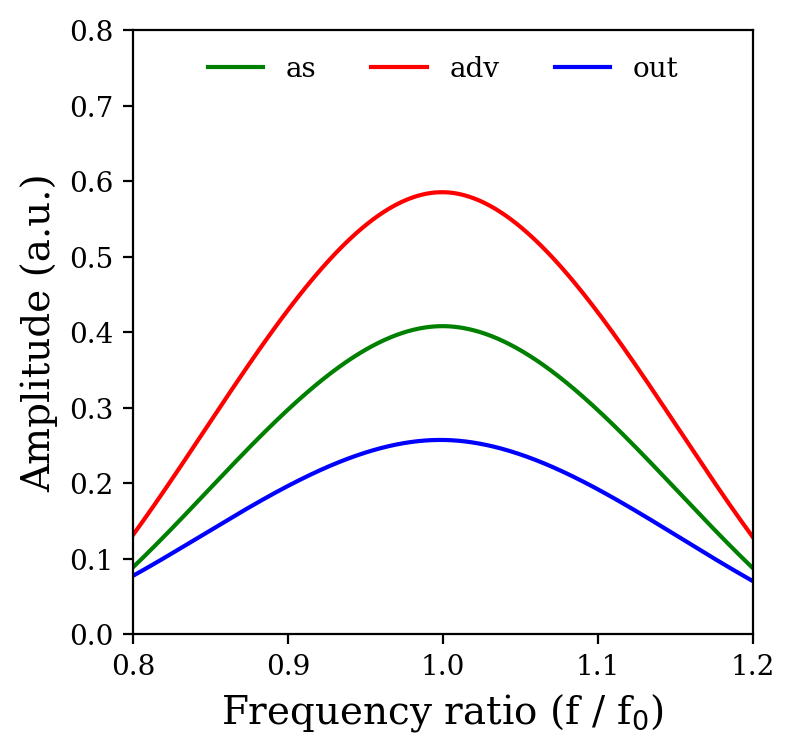

In [277]:
plt.figure(dpi=200, figsize=(4, 4))
# plot graphs
plt.plot(model_as.fft_freq1, model_as.fft1, 'g', label='as')
plt.plot(model_adv.fft_freq1, model_adv.fft1, 'r', label='adv')
plt.plot(model_out.fft_freq1, model_out.fft1, 'b', label='out')
# set labels and limits
plt.xlim([0.8, 1.2])
plt.ylim([0, 0.8])
plt.legend(loc='upper center', ncol=3, edgecolor='w')
plt.xlabel(r'Frequency ratio (f / f$_{0}$)', fontsize=14)
plt.ylabel('Amplitude (a.u.)', fontsize=14)

plt.show()

## Delay response curves of LFP

In [319]:
tau_ext = np.linspace(-2*np.pi, 2*np.pi, 50)/ w_r
# include -1/f0 & 1/f0
i1 = np.argsort(abs(tau_ext - np.pi / w_r))[0]
i2 = np.argsort(abs(tau_ext + np.pi / w_r))[0]
tau_ext[i1] = np.pi/w_r
tau_ext[i2] = -np.pi/w_r

In [324]:
model_delay = []
tic = time()
for i, t in enumerate(tau_ext):
    # calculate response to various \tau
    model_delay.append(KuramotoOsc_tf(kmax, num_osc, tmax, w0=w0, theta=theta0, ext_A1=A_as, ext_w1=w_r,
                                      ext_A2=A_os, ext_w2=w_r, tau_ext=t, dt=dt, w_r=w_r, noise_std=1.5, tau_lag=0))
    model_delay[-1].run_model()
    if (i+1) % 10 == 0:
        print("%2d done, execution time=%.3fs"%(i+1, time()-tic))
        tic = time()

10 done, execution time=115.498
20 done, execution time=116.085
30 done, execution time=115.355
40 done, execution time=115.825
50 done, execution time=115.340


In [335]:
for model in model_delay:
    add_lfp(model)
    get_ps(model)
amp = np.array([max(model.fft) for model in model_delay])

In [345]:
# "cubic" interpolation
interp = interp1d(tau_ext, amp, kind='cubic')
tau_ext1 = np.linspace(tau_ext[0], tau_ext[-1], 200)
amp1 = interp(tau_ext1)

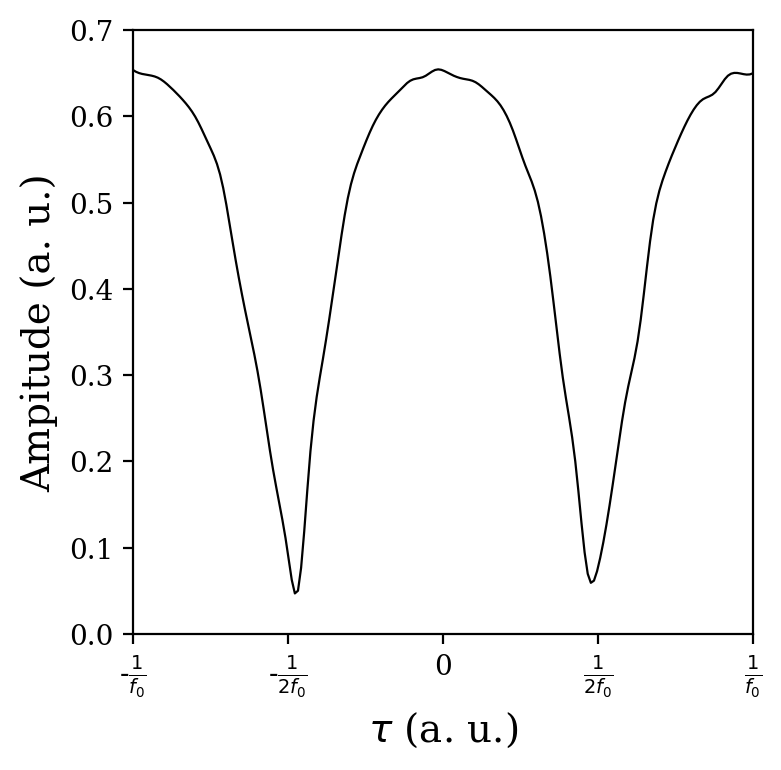

In [405]:
plt.figure(dpi=200, figsize=(4, 4))
# plot graphs
plt.plot(tau_ext1, amp1, 'k', lw=0.8)
plt.xlabel(r'$\tau$ (a. u.)', fontsize=14)
plt.ylabel('Ampitude (a. u.)', fontsize=14)
xt = np.linspace(-2*np.pi, 2*np.pi, 5) / w_r
# set labels and limits
plt.xticks(xt, [r'-$\frac{1}{f_{0}}$', r'-$\frac{1}{2f_{0}}$', 0, r'$\frac{1}{2f_{0}}$', r'$\frac{1}{f_{0}}$'])
plt.xlim([tau_ext1[0], tau_ext1[-1]])
plt.ylim([0, 0.7])
plt.show()

## Resonance curve

In [361]:
def get_mean_dev(model):
    return np.average(model.r_coh[model.t>80]), np.std(model.r_coh[model.t>80])

In [379]:
w_set = np.linspace(0.01, 2*w_r, 31)
tau_ext = [-1.25, 2.5] # adv, out
tau_lag = np.pi/6/w_set # 1/(12*f_{0})
r_mean = np.zeros([len(w_set), 3]) # as, adv, out
r_std = np.zeros([len(w_set), 3]) # as, adv, out
num_ensemble = 5

In [380]:
models = []
tic = time()
for n in range(num_ensemble): # ensemble average
    models.append([])
    w0 = abs(np.random.normal(loc=w_r, scale=0.5, size=[1, num_osc]))
    theta0 = abs(np.random.normal(loc=0, scale=20, size=[1, num_osc]))
    for i, w in enumerate(w_set):
        models[n].append([])
        for j in range(3):
            if j == 0: # assr
                model = KuramotoOsc_tf(kmax, num_osc, tmax, w0=w0, theta=theta0, ext_A1=A_as, ext_w1=w_set[i],
                                      ext_A2=0, ext_w2=0, tau_ext=0, dt=dt, w_r=w_r, noise_std=1.5, tau_lag=0)
            else: # adv, out
                model = KuramotoOsc_tf(kmax, num_osc, tmax, w0=w0, theta=theta0, ext_A1=A_as, ext_w1=w_set[i],
                                      ext_A2=A_os, ext_w2=w_set[i], tau_ext=tau_ext[j-1], dt=dt, w_r=w_r, noise_std=1.5, tau_lag=tau_lag[i])
            model.run_model()
            o1, o2 = get_mean_dev(model)
            r_mean[i, j] += o1
            r_std[i, j] += o2
            models[n][i].append(model)
        if i % 10 == 0:
            print("ensemble %2d, w# %2d Done, execution time(x10)=%.3fs"%(n, i, time()-tic))
            tic = time()
r_mean /= num_ensemble
r_std /= num_ensemble

ensemble  0, w#  0 Done, execution time(x10)=36.612s
ensemble  0, w# 10 Done, execution time(x10)=364.361s
ensemble  0, w# 20 Done, execution time(x10)=363.488s
ensemble  0, w# 30 Done, execution time(x10)=365.179s
ensemble  1, w#  0 Done, execution time(x10)=36.575s
ensemble  1, w# 10 Done, execution time(x10)=369.390s
ensemble  1, w# 20 Done, execution time(x10)=367.210s
ensemble  1, w# 30 Done, execution time(x10)=369.235s
ensemble  2, w#  0 Done, execution time(x10)=36.921s
ensemble  2, w# 10 Done, execution time(x10)=372.458s
ensemble  2, w# 20 Done, execution time(x10)=372.089s
ensemble  2, w# 30 Done, execution time(x10)=373.872s
ensemble  3, w#  0 Done, execution time(x10)=37.521s
ensemble  3, w# 10 Done, execution time(x10)=375.035s
ensemble  3, w# 20 Done, execution time(x10)=376.776s
ensemble  3, w# 30 Done, execution time(x10)=378.612s
ensemble  4, w#  0 Done, execution time(x10)=37.961s
ensemble  4, w# 10 Done, execution time(x10)=379.421s
ensemble  4, w# 20 Done, executio

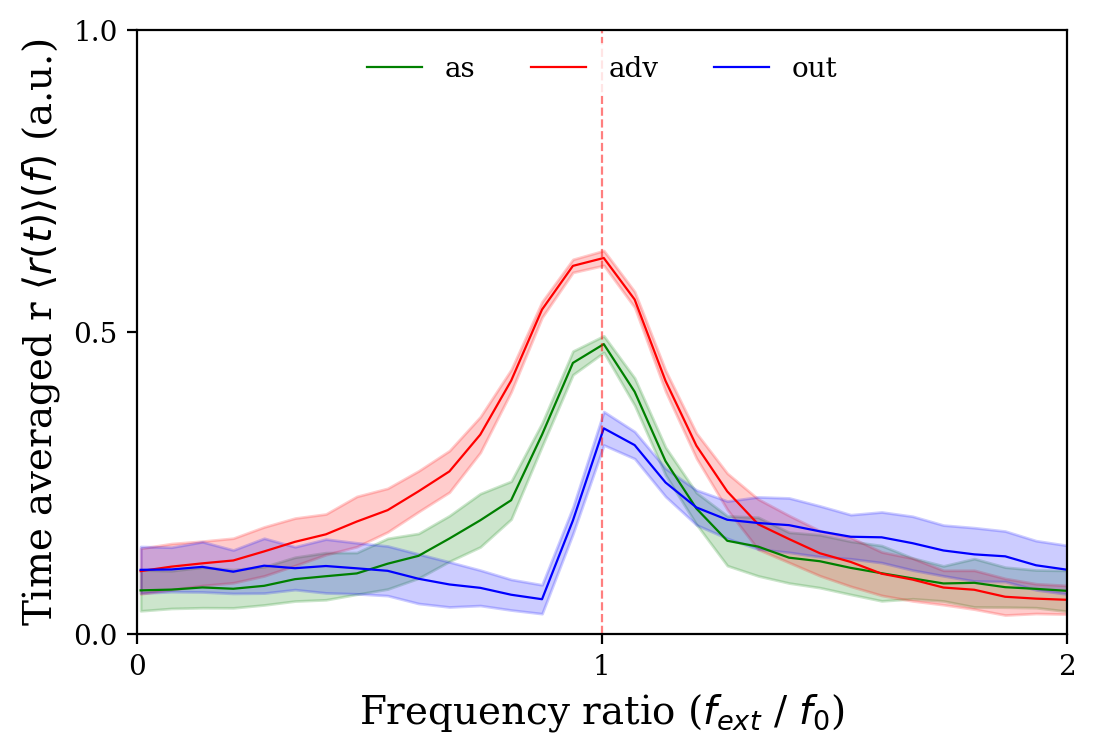

In [395]:
plt.figure(dpi=200)
colors = ['g', 'r', 'b']
labels = ['as', 'adv', 'out']
# plot graphs
for i in range(3):
    plt.plot(w_set/w_r, r_mean[:, i], colors[i], lw=0.8, label=labels[i])
    plt.fill_between(w_set/w_r, r_mean[:, i]-r_std[:, i], r_mean[:, i]+r_std[:, i], color=colors[i], alpha=0.2, edgecolor=None)
# set labels and limits
plt.xlabel('Frequency ratio ($f_{ext}$ / $f_{0}$)', fontsize=14)
plt.ylabel(r'Time averaged r $\langle r(t)\rangle(f)$ (a.u.)', fontsize=14)
plt.xlim([0, w_set[-1]/w_r])
plt.ylim([0, 1])
plt.xticks([0, 1, 2])
plt.yticks([0, 0.5, 1])
plt.plot([1, 1], [0, 1], 'r--', lw=0.8, alpha=0.5)
plt.legend(loc='upper center', ncol=3, edgecolor='w')
plt.show()